In [1]:
from pyesgf.search import SearchConnection
import xarray as xr
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)
#alternative with a bit different default settings
#conn = SearchConnection('https://esgf-data.dkrz.de/esg-search', distrib=True)
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib
import pandas as pd
import numpy as np
import re
import warnings
import os
from tqdm.notebook import tqdm
from metpy.units import units
from metpy.calc import sigma_to_pressure


In [2]:
#disabling warnings
warnings.simplefilter("ignore")
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "0"

In [3]:
#date range we're interested in
min_date = dt.strptime("1980-01-01", "%Y-%m-%d")
max_date = dt.strptime("2022-12-31", "%Y-%m-%d")

#query for experiments
var = "conccn"
exp = "historical, ssp370"
tbl = "Emon"

ctx = conn.new_context(
table_id = tbl,
variable_id = var,
experiment_id = exp,
)
if ctx.hit_count == 0:
    print("No datasets found")
    raise SystemExit()
else:
    print(ctx.hit_count)
    result = ctx.search()

249


In [4]:
##fuctions##

#creating lists for the names of unique experiments and their indexes
def models_and_idxs(*new):
    global result
    #this will ne used to initialize lists in case function to_dset fails retrive a dataset
    if new:
        model_list = new[0]
        ids = list(new[1].values())
        err_id = new[2]
    else:   
        model_list = []
        ids = []

    #going through the query result and picking the first occurance of each experiment (or the second if to_dset fails)
    for id in range(len(result)):
        match = re.findall(r"[|_\w\d-]+", result[id].dataset_id)
        if not (match[3],match[4]) in model_list and id not in ids and len(result[id].file_context().search()) != 0:
            model_list.append((match[3],match[4]))
            ids.append(id)
    #deleting failed ids if to_dset fails
    if new:
        [ids.remove(id) for id in err_id]
    #making sure that each model has both historical and scenario parts
    d = {}
    new_ids = []
    new_models = []
    for x, y in zip(model_list, ids):
        if x[0] in d:
            new_ids += [d[x[0]][1], y]
            new_models += [d[x[0]][0], x]
        else:
            d[x[0]] = [x, y]
    return dict(sorted(zip(new_models, new_ids)))

#collecting files of the wanted time period
def filter_dates(model_dict):
    global result
    file_dict = {}
    #only files that contain data from the chosen data onwards are taken
    for model, id in model_dict.items():
        files = (result[id].file_context().search())
        for file in files:
            try:
                x = re.search(r"(1[89]|2[01])\d{4}-\d{6}",file.opendap_url)
                x = x.group().split("-")
                x1 = dt.strptime(x[0], "%Y%m")
                x2 = dt.strptime(x[1], "%Y%m")
                #in the example the period is 1.1.1980-
                if x1 <= min_date <= x2 or (x1 >= min_date and x2 <= max_date) or x1 <= max_date <= x2:
                    file_dict.setdefault(model, []).append(file)
            except:
                #in the rare occation where a file isn't found, it must be skipped. It seems like choosing a replica doesn't help 
                #so nothing is done about this
                if model in file_dict:
                    del file_dict[model]
                break
    return file_dict


#reading datasets, failed attempts are repeated once to see if a copy exists
def to_dset(file_dict, model_dict, *i):
    global result
    dsets = {}
    err_id = []
    err_name = []
    length = 0
    for id, name, files in zip(model_dict.values(), file_dict.keys(), file_dict.values()):
        for file in files:
            try:
                dset = xr.open_dataset(file.opendap_url)
                dsets.setdefault(name[0], []).append(dset)
                length += 1
            except:
                print(id, name)
                err_id.append(id)
                err_name.append(name)
    #only one layer of recurion is allowed
    if i:
        return dsets, length
    #new try if the initial failed with some datasets
    if len(err_id) > 0:
        err_name = list(set(err_name))
        err_id = list(set(err_id))
        new_models = ([name for name in file_dict.keys() if name not in err_name])
        new_model_dict= models_and_idxs(new_models, model_dict, err_id)
        new_file_dict = filter_dates(new_model_dict)
        dset2, length2 = to_dset(new_file_dict, model_dict, i)
        if dset2 != None:
            dsets = dsets | dset2
            length += length2
    return dsets, length

In [5]:
model_dict = models_and_idxs()

In [6]:
file_dict = filter_dates(model_dict)

In [7]:
dsets, length = to_dset(file_dict, model_dict)

In [8]:
def height(pressure):
    if pressure.lev.units == "m":
        return pressure
    elif pressure.lev.units == "1" or pressure.lev.units == "1.0":
        levels = sigma_to_pressure(pressure.lev.values, 1000*units.hPa, 0*units.hPa)
        levels = levels.magnitude
    elif pressure.lev.units == "hPa":
        levels = pressure.lev.values
    elif pressure.lev.units == "Pa":
        levels = pressure.lev.values/1000
    height = [(145366.45*(1-(abs(P/1013.25))**0.190284))*0.3048 for P in levels]
    pressure = pressure.assign_coords(lev=height)
    return pressure

#narrowing down the coordinates and time
ds = {}
con = "0"
#i = 0
with tqdm(total=length, colour="green") as pbar:
    for dset in dsets:
        for elem in dsets[dset]:
            if "lev" in elem.dims or "presnivs" in elem.dims:
                if "presnivs" in elem.dims:
                    elem = elem.rename({"presnivs": "lev"})
                elem = height(elem)
            elem_var = elem[var]
            #renaming the dims since they're not always consistent. Some datasets have 4 and some 3 dimensions
            if len(elem_var.dims) == 4:
                elem_var = elem_var.rename({elem_var.dims[0] : "time", elem_var.dims[1] : "lev", elem_var.dims[2] : "lat", elem_var.dims[3] : "lon"})     
            else:
                elem_var = elem_var.rename({elem_var.dims[0] : "time", elem_var.dims[1] : "lat", elem_var.dims[2] : "lon"})
            #choosing the nearest grid cell to wanted location
            lat = min(elem_var.lat, key=lambda x:abs(x-67.97))
            lon = min(elem_var.lon, key=lambda x:abs(x-24.12))
            
            #normalizing date formats 
            elem_var["time"] = elem_var["time"].astype("datetime64[ns]")

            #narrowing down spatial data
            if "lev" in elem_var.dims:
                lev = min(elem_var.lev, key=lambda x: abs(x-555.0))
                temp = elem_var.sel(lat=lat, lon=lon, lev=lev)
            else: 
                temp = elem_var.sel(lat=lat, lon=lon)
            
            temp = pd.DataFrame({"Time" : temp.time, "Values" : temp.values})
            #concatenate data if more than one dataset per experiment
            if len(con) != 1 and len(dsets[dset]) != 1:
                con = pd.concat([con, temp])
            else:
                con = temp
            #i += 1
            #pbar.write('Processed: %d' %i)
            pbar.update(1)
        #narrowing down temporal data
        con = con[(max_date >= con["Time"]) & (con["Time"] >= min_date)]
        con = con.reset_index()
        ds[dset] = con
        con = "0"

  0%|          | 0/15 [00:00<?, ?it/s]

Text(0, 0.5, 'Aerosol Number Concentration \n [cm^3]')

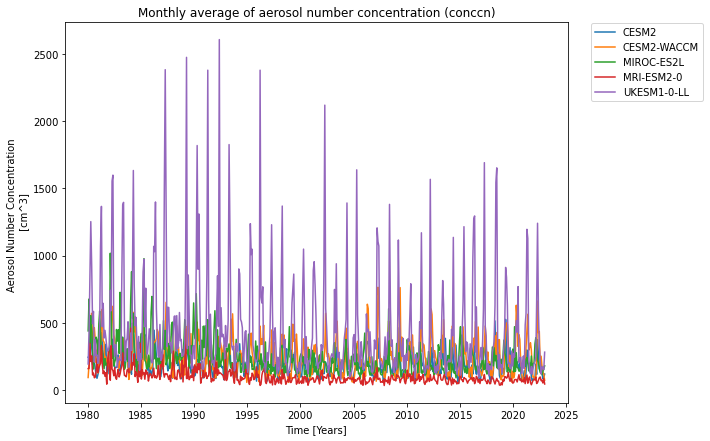

In [9]:
#monthly plot
fig = plt.figure(figsize=(9,7))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
for model, data in ds.items():
    #plot each model, 1e-6 corrects the unit from m^-3 to cm^-3
    plt.plot(data["Time"],data["Values"]*1e-6, label=model)
plt.legend()

# #these parameters (x,y) might have to be motified depending of the data
plt.legend(bbox_to_anchor=(1.28,1.01))
try:
    long_name = dsets[list(dsets.keys())[0]][0][var].long_name
    name = var
    plt.title(f"Monthly average of {long_name.lower()} ({name})")
except:
    plt.title(f"Monthly average of {name}")
plt.xlabel("Time [Years]")
plt.ylabel(f"{long_name} \n [cm^3]")
# #fig.savefig(f"{str(name)}_yearly.pdf", bbox_inches="tight")

In [10]:
def weighted_temporal_mean(ds):
  #source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
  """
  weight by days in each month
  """
  # Determine the month length, days in year
  month_length = pd.DataFrame({"Time" : ds["Time"], "D_in_M" : ds["Time"].dt.days_in_month})
  month_length["D_in_Y"] = np.where(ds["Time"].dt.is_leap_year, 366, 365)
  # Calculate the weights
  month_length["wgts"] = month_length["D_in_M"] / month_length["D_in_Y"]
  # Make sure the weights in each year add up to 1
  np.testing.assert_allclose(month_length["wgts"].groupby(month_length["Time"].dt.year).sum(), 1.0)
  #print(sum(month_length["D_in_M"]))

  # Setup our masking for nan values
  cond = ds["Values"].isnull()
  ones = np.where(cond, 0.0, 1.0)
  # Calculate the numerator
  month_length["obs_sum"] = (ds["Values"]*1e-6 * month_length["wgts"])
  # Calculate the denominator
  month_length["ones_out"] = (ones * month_length["wgts"].values)
  month_length = month_length.groupby(month_length["Time"].dt.year).sum()
  # Return the weighted average
  month_length["weighted"] =  (month_length["obs_sum"].values / month_length["ones_out"].values)
  #month_length = month_length.groupby(month_length["Time"].dt.year).sum()
  return month_length

In [11]:
#create a trend line for yearly plots
def plot_trend(tdata):
    x = np.linspace(0, 100, len(tdata["weighted"]))
    y = tdata["weighted"]
    #calculate equation for trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    return p(x), p[1]


Text(0, 0.5, 'Aerosol Number Concentration \n [cm^3]')

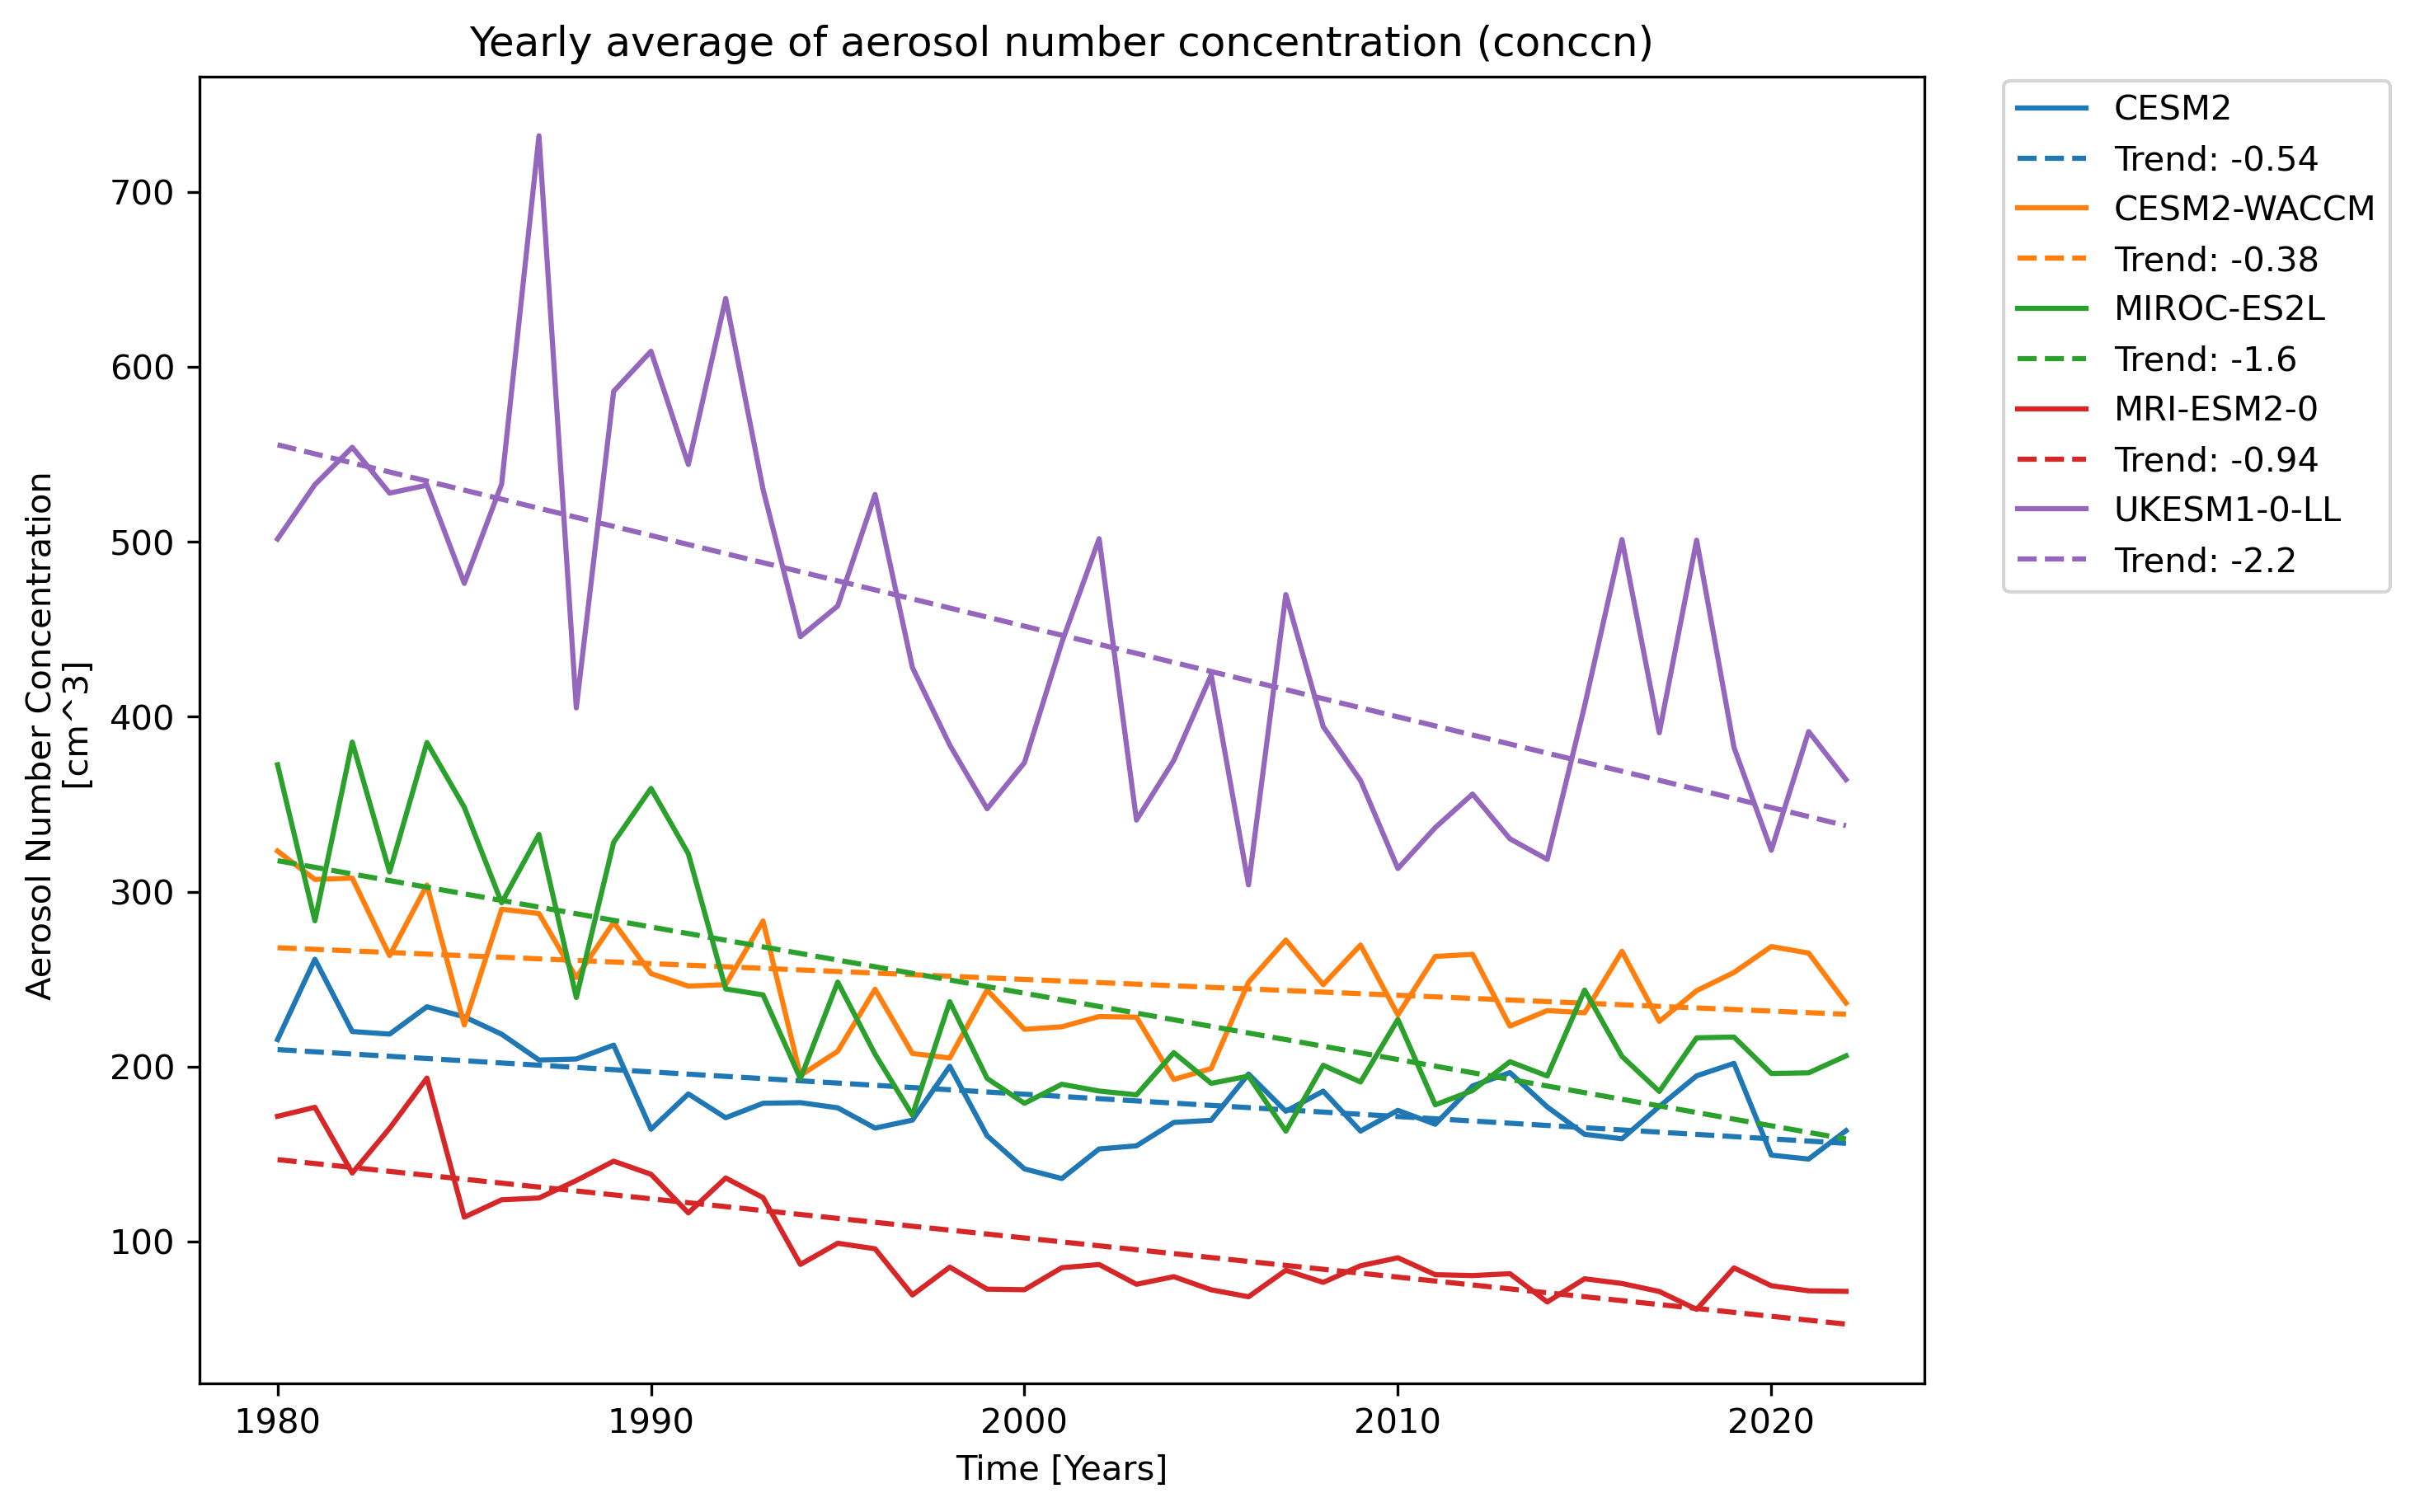

In [12]:
#yearly plot
fig = plt.figure(figsize=(9,7))
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
for model, data in ds.items():
    #weigh data by the month lenght
    data = weighted_temporal_mean(data).reset_index()
    #same color for data and trend
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    #plot each model, 1e-6 corrects the unit from m^-3 to cm^-3
    plt.plot(data["Time"],data["weighted"], label=model, color=color)
    plt.plot(data["Time"], plot_trend(data)[0], label=f"Trend: {plot_trend(data)[1]:.2}", color=color, linestyle="--")
#these parameters (x,y) might have to be motified depending of the data
plt.legend(bbox_to_anchor=(1.28,1.01))
try:
    long_name = dsets[list(dsets.keys())[0]][0][var].long_name
    name = var
    plt.title(f"Yearly average of {long_name.lower()} ({name})")
except:
    plt.title(f"Yearly average of {name}")
plt.xlabel("Time [Years]")
plt.ylabel(f"{long_name} \n [cm^3]")
# #fig.savefig(f"{str(name)}_yearly.pdf", bbox_inches="tight")